# Installs & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import (
    CubicHermiteSpline,
    lagrange,
    BarycentricInterpolator,
    interp1d,
    UnivariateSpline,
    splrep,
    splev,
    Rbf,
    CubicSpline,
    BSpline,
    PchipInterpolator
)
from numpy.polynomial import Chebyshev

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge

import requests, io
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Data Loading

In [2]:
def load_data(url: str) -> pd.DataFrame:
    """Download csv data from a url and parse dates"""
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download dataset from {url}")
    df = pd.read_csv(io.StringIO(response.text), parse_dates=['Date'])
    # Rename 'Date' to 'date' and 'Temp' to 'temp'
    df.rename(columns={'Date': 'date', 'Temp': 'temp'}, inplace=True)
    return df

In [3]:
# Load dataset
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = load_data(data_url)
print("Raw data sample:")
display(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Raw data sample:


,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8



Missing values per column:
date    0
temp    0
dtype: int64


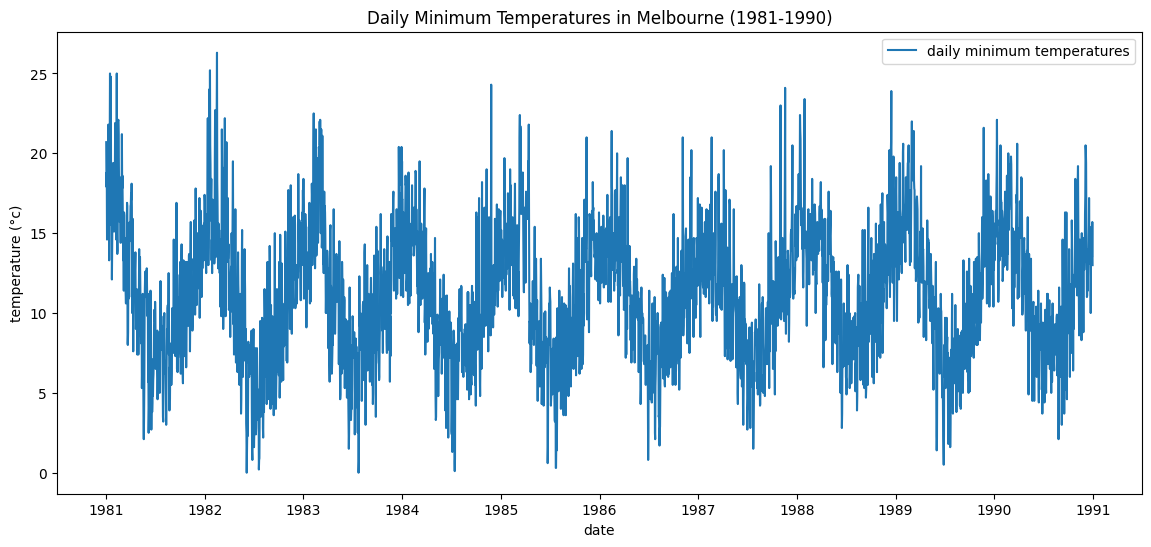

In [4]:
# Plot raw data
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['temp'], label='daily minimum temperatures')
plt.title('Daily Minimum Temperatures in Melbourne (1981-1990)')
plt.xlabel('date')
plt.ylabel('temperature (°c)')
plt.legend()
plt.show()

# Data Preparation

## Data Splitting

In [5]:
def split_and_prepare_data(df: pd.DataFrame, split_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame, MinMaxScaler):
    """
    Splits the raw dataframe into training and test sets
    Creates a time index and scales the temperature values using training data only
    """
    split_index = int(len(df) * split_ratio)
    train_df = df.iloc[:split_index].copy()
    test_df = df.iloc[split_index:].copy()

    # Create time index: training uses 0,1,2,...; test continues from that
    train_df['time_idx'] = np.arange(len(train_df))
    test_df['time_idx'] = np.arange(len(train_df), len(train_df) + len(test_df))

    # Scale using training data only
    scaler = MinMaxScaler()
    train_df['value_scaled'] = scaler.fit_transform(train_df[['temp']])
    test_df['value_scaled'] = scaler.transform(test_df[['temp']])

    return train_df, test_df, scaler

In [6]:
# Use the function
train_df, test_df, scaler = split_and_prepare_data(df)

# Shapes
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (2920, 4)
Test set shape: (730, 4)


## Interpolation

In [7]:
def introduce_missingness(train_df: pd.DataFrame, missing_ratio: float = 0.1) -> pd.DataFrame:
    """
    Introduces missing values randomly into the scaled training data
    Adds a column 'value_scaled_missing' to hold the data with missingness
    """
    train_df = train_df.copy()
    train_df['value_scaled_missing'] = train_df['value_scaled'].copy()
    n_train = len(train_df)
    n_missing = int(n_train * missing_ratio)
    missing_indices = np.random.choice(train_df.index, size=n_missing, replace=False)
    train_df.loc[missing_indices, 'value_scaled_missing'] = np.nan
    print(f"Missing values introduced: {train_df['value_scaled_missing'].isnull().sum()} / {n_train}")
    return train_df

In [8]:
# Use the function
train_df = introduce_missingness(train_df, missing_ratio=0.1)

Missing values introduced: 292 / 2920


In [9]:
def plot_missing_data(df: pd.DataFrame):
    """Plot original scaled series and series with missing values"""
    plt.figure(figsize=(14, 6))
    plt.plot(df['time_idx'], df['value_scaled'], label='original scaled')
    plt.plot(df['time_idx'], df['value_scaled_missing'], 'o', label='with missing', markersize=3)
    plt.title('Training Set: Scaled Series with Introduced Missing Values')
    plt.xlabel('time_idx')
    plt.ylabel('scaled value')
    plt.legend()
    plt.show()

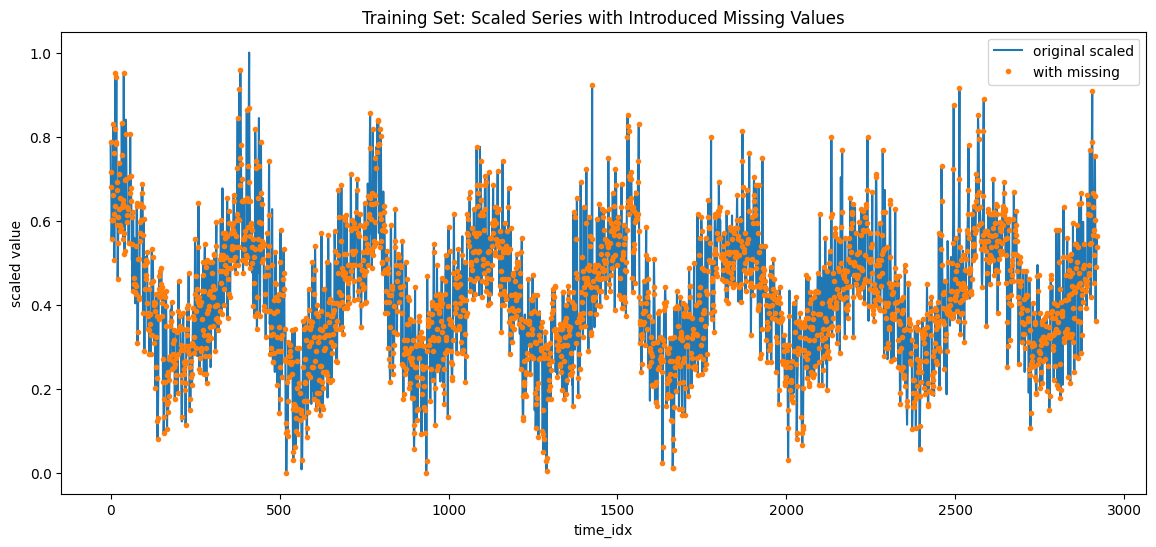

In [10]:
# Use the function
plot_missing_data(train_df)

In [11]:
def fill_missing_values(data: np.ndarray) -> np.ndarray:
    """
    Fill missing values in the data using linear interpolation,
    with backfill and forward fill as necessary
    """
    return pd.Series(data).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill').values

In [12]:
def sanitize_interpolation(y_interp: np.ndarray, lower_bound: float = 0.0, upper_bound: float = 1.0) -> np.ndarray:
    """
    Ensure that the interpolated values are finite.
    Replace non-finite values via linear interpolation and then clip the output to [lower_bound, upper_bound]
    """
    # Replace non-finite values with NaN
    y_interp[~np.isfinite(y_interp)] = np.nan
    # Fill NaNs using Pandas interpolation (linear, then backfill and forward-fill)
    s = pd.Series(y_interp).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    y_interp = s.values
    # Use np.nan_to_num to replace any residual nans or inf
    y_interp = np.nan_to_num(y_interp, nan=lower_bound, posinf=upper_bound, neginf=lower_bound)
    # Clip to the expected range
    y_interp = np.clip(y_interp, lower_bound, upper_bound)
    # Debug print: show min and max of sanitized output
    print("Sanitized interpolation: min =", np.min(y_interp), "max =", np.max(y_interp))
    return y_interp

In [13]:
def compute_derivative(y: np.ndarray) -> np.ndarray:
    """
    Compute derivative using central differences; for endpoints, use forward/backward difference
    """
    dy = np.empty_like(y)
    dy[0] = y[1] - y[0]     # forward difference for first element
    dy[-1] = y[-1] - y[-2]  # backward difference for last element
    for i in range(1, len(y) - 1):
        dy[i] = (y[i + 1] - y[i - 1]) / 2.0
    return dy

In [14]:
def lagrange_interpolation(data: np.ndarray, subset_size: int = 20) -> np.ndarray:
    valid = np.isfinite(data)  # Use only observed (non-missing) data
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    if len(x_valid) < subset_size:
        subset_size = len(x_valid)
    indices = np.linspace(0, len(x_valid) - 1, subset_size, dtype=int)
    x_subset = x_valid[indices]
    y_subset = y_valid[indices]
    poly = lagrange(x_subset, y_subset)
    y_interp = poly(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def newton_interpolation(data: np.ndarray, subset_size: int = 20) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    if len(x_valid) < subset_size:
        subset_size = len(x_valid)
    indices = np.linspace(0, len(x_valid) - 1, subset_size, dtype=int)
    x_subset = x_valid[indices]
    y_subset = y_valid[indices]
    interpolator = BarycentricInterpolator(x_subset, y_subset)
    y_interp = interpolator(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def cubic_spline_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    cs = CubicSpline(x_valid, y_valid)
    y_interp = cs(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def chebyshev_interpolation(data: np.ndarray, deg: int = 5, nodes: int = 20) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    cs = CubicSpline(x_valid, y_valid)
    cheb_nodes = np.cos((2 * np.arange(nodes) + 1) / (2 * nodes) * np.pi)
    x_cheb = 0.5 * (x_valid.max() + x_valid.min()) + 0.5 * (x_valid.max() - x_valid.min()) * cheb_nodes
    y_cheb = cs(x_cheb)
    cheb_poly = Chebyshev.fit(x_cheb, y_cheb, deg=deg)
    y_interp = cheb_poly(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def rational_spline_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    us = UnivariateSpline(x_valid, y_valid, k=3, s=1)
    y_interp = us(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def rbf_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    rbf_int = Rbf(x_valid, y_valid, function='multiquadric', smooth=0.1)
    y_interp = rbf_int(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def cubic_hermite_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    cs = CubicHermiteSpline(x_valid, y_valid, compute_derivative(y_valid))
    y_interp = cs(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def interp1d_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    f = interp1d(x_valid, y_valid, kind='linear', fill_value="extrapolate")
    y_interp = f(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def auto_bspline_interpolation(data: np.ndarray, degree: int = 5) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    if len(x_valid) < 2:
        return sanitize_interpolation(data)
    t, c, k = splrep(x_valid, y_valid, k=degree)
    bspl = BSpline(t, c, k)
    y_interp = bspl(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

def pchip_interpolation(data: np.ndarray) -> np.ndarray:
    valid = np.isfinite(data)
    x_valid = np.arange(len(data))[valid]
    y_valid = data[valid]
    pchip = PchipInterpolator(x_valid, y_valid)
    y_interp = pchip(np.arange(len(data)))
    return sanitize_interpolation(y_interp)

In [15]:
# Use the same missing training series for all interpolation methods
train_missing = train_df['value_scaled_missing'].values

In [16]:
# Use the interpolation methods
interpolated_methods = {
    'lagrange': lagrange_interpolation(train_missing),
    'newton': newton_interpolation(train_missing),
    'cubic_spline': cubic_spline_interpolation(train_missing),
    'chebyshev': chebyshev_interpolation(train_missing),
    'rational_spline': rational_spline_interpolation(train_missing),
    'rbf': rbf_interpolation(train_missing),
    'cubic_hermite': cubic_hermite_interpolation(train_missing),
    'interp1d': interp1d_interpolation(train_missing),
    'auto_bspline': auto_bspline_interpolation(train_missing),
    'pchip': pchip_interpolation(train_missing)
}

Sanitized interpolation: min = 0.0 max = 1.0
Sanitized interpolation: min = 0.0 max = 1.0
Sanitized interpolation: min = 0.0 max = 0.9581749049429658
Sanitized interpolation: min = 0.37414057913928866 max = 0.5502922624729869
Sanitized interpolation: min = 0.0 max = 0.9478976375409054
Sanitized interpolation: min = 0.0 max = 0.9058446212693525
Sanitized interpolation: min = 0.0 max = 0.9581749049429658
Sanitized interpolation: min = 0.0 max = 0.9581749049429658
Sanitized interpolation: min = 0.0 max = 1.0
Sanitized interpolation: min = 0.0 max = 0.9581749049429658


## Feature Engineering

In [17]:
def create_features(values: np.ndarray, roc: np.ndarray, time_idx: np.ndarray, window_size: int, period: int = 365):
    """
    Create forecasting features from a series
    For each time step i (starting at window_size), features include:
      - Lag features: previous window_size values
      - Lag features of rate-of-change
      - Current time index
      - Fourier features: sin and cos of time index
    Returns X (feature matrix) and y (target vector)
    """
    X, y = [], []
    for i in range(window_size, len(values)):
        lags_val = values[i-window_size:i]
        lags_roc = roc[i-window_size:i]
        t = time_idx[i]
        sin_feature = np.sin(2 * np.pi * t / period)
        cos_feature = np.cos(2 * np.pi * t / period)
        features = np.concatenate([lags_val, lags_roc, [t, sin_feature, cos_feature]])
        X.append(features)
        y.append(values[i])
    return np.array(X), np.array(y)

In [18]:
def create_test_features(
    train_values: np.ndarray, test_values: np.ndarray,
    train_roc: np.ndarray, test_roc: np.ndarray,
    train_time: np.ndarray, test_time: np.ndarray,
    window_size: int, period: int = 365
):
    """
    Create forecasting features for the test set
    Combines the last window_size points of training with test data
    Returns X_test and y_test
    """
    combined_values = np.concatenate([train_values, test_values])
    combined_roc = np.concatenate([train_roc, test_roc])
    combined_time = np.concatenate([train_time, test_time])

    X_test, y_test = [], []
    for i in range(len(train_values), len(combined_values)):
        lags_val = combined_values[i-window_size:i]
        lags_roc = combined_roc[i-window_size:i]
        t = combined_time[i]
        sin_feature = np.sin(2 * np.pi * t / period)
        cos_feature = np.cos(2 * np.pi * t / period)
        features = np.concatenate([lags_val, lags_roc, [t, sin_feature, cos_feature]])
        X_test.append(features)
        y_test.append(combined_values[i])
    return np.array(X_test), np.array(y_test)

# Model Fitting

In [19]:
def train_model(X: np.ndarray, y: np.ndarray, model_type: str = "lr"):
    """
    Train a forecasting model: linear regression ('lr') or ridge
    """
    if model_type == "lr":
        model = LinearRegression()
    elif model_type == "ridge":
        model = Ridge()
    else:
        raise ValueError("Model type must be 'lr' or 'ridge'")
    model.fit(X, y)
    return model

In [20]:
# Forecasting parameters
window_size = 30
period = 365

# Extract training and test time arrays
train_time = train_df['time_idx'].values
test_time = test_df['time_idx'].values

# Use complete training values (without missing) for computing rate-of-change for features
train_values_complete = train_df['value_scaled'].values
eps = 1e-6
# Compute robust pct_change: add a small epsilon to avoid division by zero
train_roc_complete = ((pd.Series(train_values_complete) - pd.Series(train_values_complete).shift(1)) /
                      (pd.Series(train_values_complete).shift(1) + eps)).fillna(0).replace([np.inf, -np.inf], 0).values

# For test set, use complete scaled values and compute rate-of-change similarly
test_values = test_df['value_scaled'].values
test_roc = ((pd.Series(test_values) - pd.Series(test_values).shift(1)) /
            (pd.Series(test_values).shift(1) + eps)).fillna(0).replace([np.inf, -np.inf], 0).values

In [21]:
# Dictionaries to store models and predictions
models_lr = {}
models_ridge = {}
predictions_lr = {}
predictions_ridge = {}

for method, interp_train in interpolated_methods.items():
    # Compute rate-of-change on the interpolated training series for this method
    train_roc = ((pd.Series(interp_train) - pd.Series(interp_train).shift(1)) /
                 (pd.Series(interp_train).shift(1) + eps)).fillna(0).replace([np.inf, -np.inf], 0).values

    # Create forecasting features for training using the interpolated series
    X_train, y_train = create_features(interp_train, train_roc, train_time, window_size, period)

    # Debug print: check range of X_train
    print(f"{method} - X_train: min={np.min(X_train)}, max={np.max(X_train)}")

    # Train models
    model_lr = train_model(X_train, y_train, model_type="lr")
    model_ridge = train_model(X_train, y_train, model_type="ridge")
    models_lr[method] = model_lr
    models_ridge[method] = model_ridge

    # Create test features using the interpolated training series (for lags) and test set values
    X_test, y_test = create_test_features(interp_train, test_values, train_roc, test_roc, train_time, test_time, window_size, period)

    # Forecast (predictions on the normalized scale)
    pred_lr_scaled = model_lr.predict(X_test)
    pred_ridge_scaled = model_ridge.predict(X_test)

    # Inverse-transform predictions to original temperature scale
    pred_lr = scaler.inverse_transform(pred_lr_scaled.reshape(-1, 1)).flatten()
    pred_ridge = scaler.inverse_transform(pred_ridge_scaled.reshape(-1, 1)).flatten()

    predictions_lr[method] = pred_lr
    predictions_ridge[method] = pred_ridge

    print(f"Method: {method}")
    print(f"  Training samples: {X_train.shape[0]}, Test predictions: {len(pred_lr)}\n")

lagrange - X_train: min=-0.9999977249865941, max=123170.73008965896
Method: lagrange
  Training samples: 2890, Test predictions: 730

newton - X_train: min=-0.9999973163337328, max=123170.72999931495
Method: newton
  Training samples: 2890, Test predictions: 730

cubic_spline - X_train: min=-0.9999960151673942, max=98859.31558935362
Method: cubic_spline
  Training samples: 2890, Test predictions: 730

chebyshev - X_train: min=-0.9999907397361901, max=2919.0
Method: chebyshev
  Training samples: 2890, Test predictions: 730

rational_spline - X_train: min=-0.9999907397361901, max=101169.02244403827
Method: rational_spline
  Training samples: 2890, Test predictions: 730

rbf - X_train: min=-0.9999907397361901, max=71893.84026332846
Method: rbf
  Training samples: 2890, Test predictions: 730

cubic_hermite - X_train: min=-0.9999960151673942, max=26615.96958174905
Method: cubic_hermite
  Training samples: 2890, Test predictions: 730

interp1d - X_train: min=-0.9999960151673942, max=49429.65

# Metrics Evaluation

In [22]:
def evaluate_forecast(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [23]:
# Dictionaries to store metrics
evaluation_metrics_lr = {}
evaluation_metrics_ridge = {}

# y_test from create_test_features is on normalized scale; inverse-transform y_test to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

for method in predictions_lr.keys():
    metrics_lr = evaluate_forecast(y_test_original, predictions_lr[method])
    metrics_ridge = evaluate_forecast(y_test_original, predictions_ridge[method])
    evaluation_metrics_lr[method] = metrics_lr
    evaluation_metrics_ridge[method] = metrics_ridge

    print(f"Method: {method}")
    print(f"  LR:  RMSE={metrics_lr['RMSE']:.4f}, MAE={metrics_lr['MAE']:.4f}, MAPE={metrics_lr['MAPE']:.4f}")
    print(f"  Ridge: RMSE={metrics_ridge['RMSE']:.4f}, MAE={metrics_ridge['MAE']:.4f}, MAPE={metrics_ridge['MAPE']:.4f}\n")

Method: lagrange
  LR:  RMSE=3.9655, MAE=2.8692, MAPE=0.2958
  Ridge: RMSE=3.6415, MAE=2.1623, MAPE=0.2269

Method: newton
  LR:  RMSE=3.6005, MAE=2.6580, MAPE=0.2745
  Ridge: RMSE=3.3662, MAE=2.1256, MAPE=0.2246

Method: cubic_spline
  LR:  RMSE=2.1662, MAE=1.7210, MAPE=0.2026
  Ridge: RMSE=2.1627, MAE=1.7162, MAPE=0.2029

Method: chebyshev
  LR:  RMSE=3.1757, MAE=2.5317, MAPE=0.2823
  Ridge: RMSE=2.5875, MAE=1.9836, MAPE=0.2506

Method: rational_spline
  LR:  RMSE=2.2824, MAE=1.8335, MAPE=0.2093
  Ridge: RMSE=2.2226, MAE=1.7785, MAPE=0.2050

Method: rbf
  LR:  RMSE=2.9333, MAE=2.3434, MAPE=0.2531
  Ridge: RMSE=2.4039, MAE=1.9243, MAPE=0.2143

Method: cubic_hermite
  LR:  RMSE=2.1592, MAE=1.7139, MAPE=0.2020
  Ridge: RMSE=2.1585, MAE=1.7117, MAPE=0.2024

Method: interp1d
  LR:  RMSE=2.1595, MAE=1.7125, MAPE=0.2021
  Ridge: RMSE=2.1606, MAE=1.7120, MAPE=0.2027

Method: auto_bspline
  LR:  RMSE=2.1797, MAE=1.7365, MAPE=0.2041
  Ridge: RMSE=2.1718, MAE=1.7276, MAPE=0.2040

Method: pchip


In [24]:
# Create metrics DataFrames
metrics_df_lr = pd.DataFrame(evaluation_metrics_lr).T
metrics_df_ridge = pd.DataFrame(evaluation_metrics_ridge).T

print("Linear Regression Metrics:")
display(metrics_df_lr)
print("\nRidge Regression Metrics:")
display(metrics_df_ridge)

Linear Regression Metrics:


,RMSE,MAE,MAPE
lagrange,3.965512,2.869180,0.295821
newton,3.600461,2.658047,0.274485
cubic_spline,2.166174,1.720983,0.202593
chebyshev,3.175708,2.531737,0.282304
rational_spline,2.282394,1.833498,0.209330
rbf,2.933266,2.343363,0.253128
cubic_hermite,2.159157,1.713931,0.201950
interp1d,2.159495,1.712470,0.202059
auto_bspline,2.179705,1.736504,0.204057
pchip,2.158783,1.712142,0.201894



Ridge Regression Metrics:


,RMSE,MAE,MAPE
lagrange,3.641542,2.162288,0.226948
newton,3.366203,2.125616,0.224606
cubic_spline,2.162676,1.716219,0.202877
chebyshev,2.587499,1.983567,0.250563
rational_spline,2.222616,1.778504,0.205026
rbf,2.403939,1.924301,0.214312
cubic_hermite,2.158481,1.711652,0.202426
interp1d,2.160568,1.711974,0.202659
auto_bspline,2.171786,1.727576,0.203952
pchip,2.159213,1.711271,0.202470


# Metrics Plotting

In [25]:
def plot_metrics(metrics_df: pd.DataFrame, title: str):
    metrics = ['RMSE', 'MAE', 'MAPE']
    methods = metrics_df.index.tolist()
    x = np.arange(len(methods))
    width = 0.25

    # Calculate the maximum bar height across all metrics
    max_bar_height = metrics_df.max().max()

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, metrics_df[metric].values, width, label=metric)
        for j, value in enumerate(metrics_df[metric].values):
            # Add a small offset
            y_offset = 0.02 * max_bar_height
            ax.text(x[j] + i * width, value + y_offset, f'{value:.2f}',
                    ha='center', va='bottom', fontsize=8, rotation=45)

    # Increase the top y-limit
    ax.set_ylim(top=max_bar_height * 1.2)

    ax.set_xticks(x + width)
    ax.set_xticklabels(methods, rotation=45)
    ax.set_ylabel('metric value')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

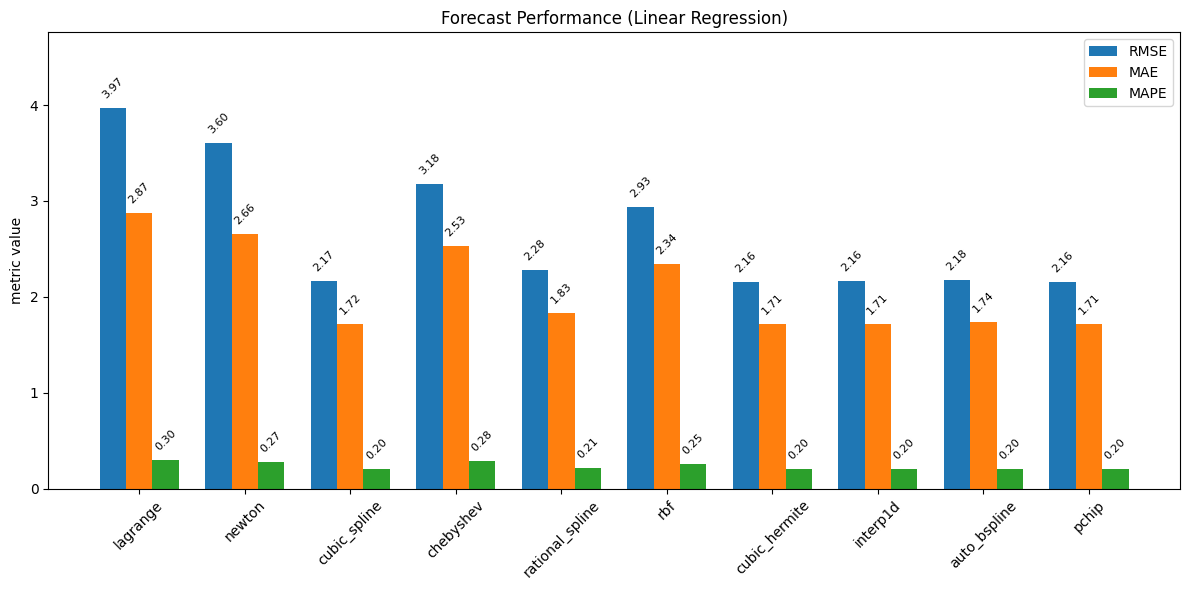

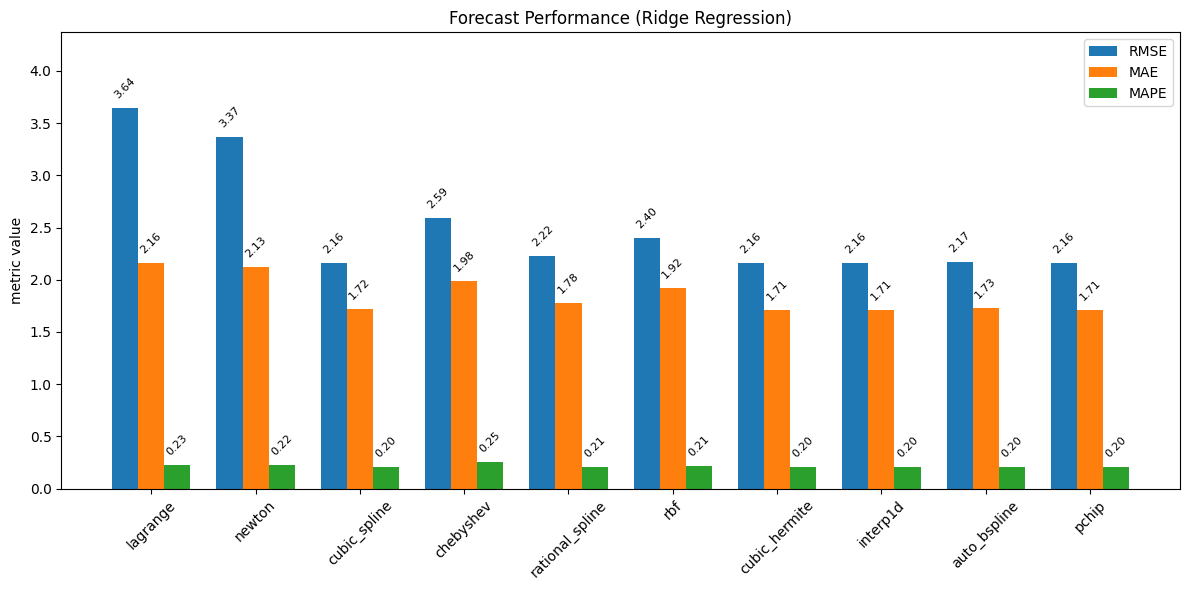

In [26]:
# Display grouped bar plots
plot_metrics(metrics_df_lr, "Forecast Performance (Linear Regression)")
print("\n")
plot_metrics(metrics_df_ridge, "Forecast Performance (Ridge Regression)")

# Forecast Plotting

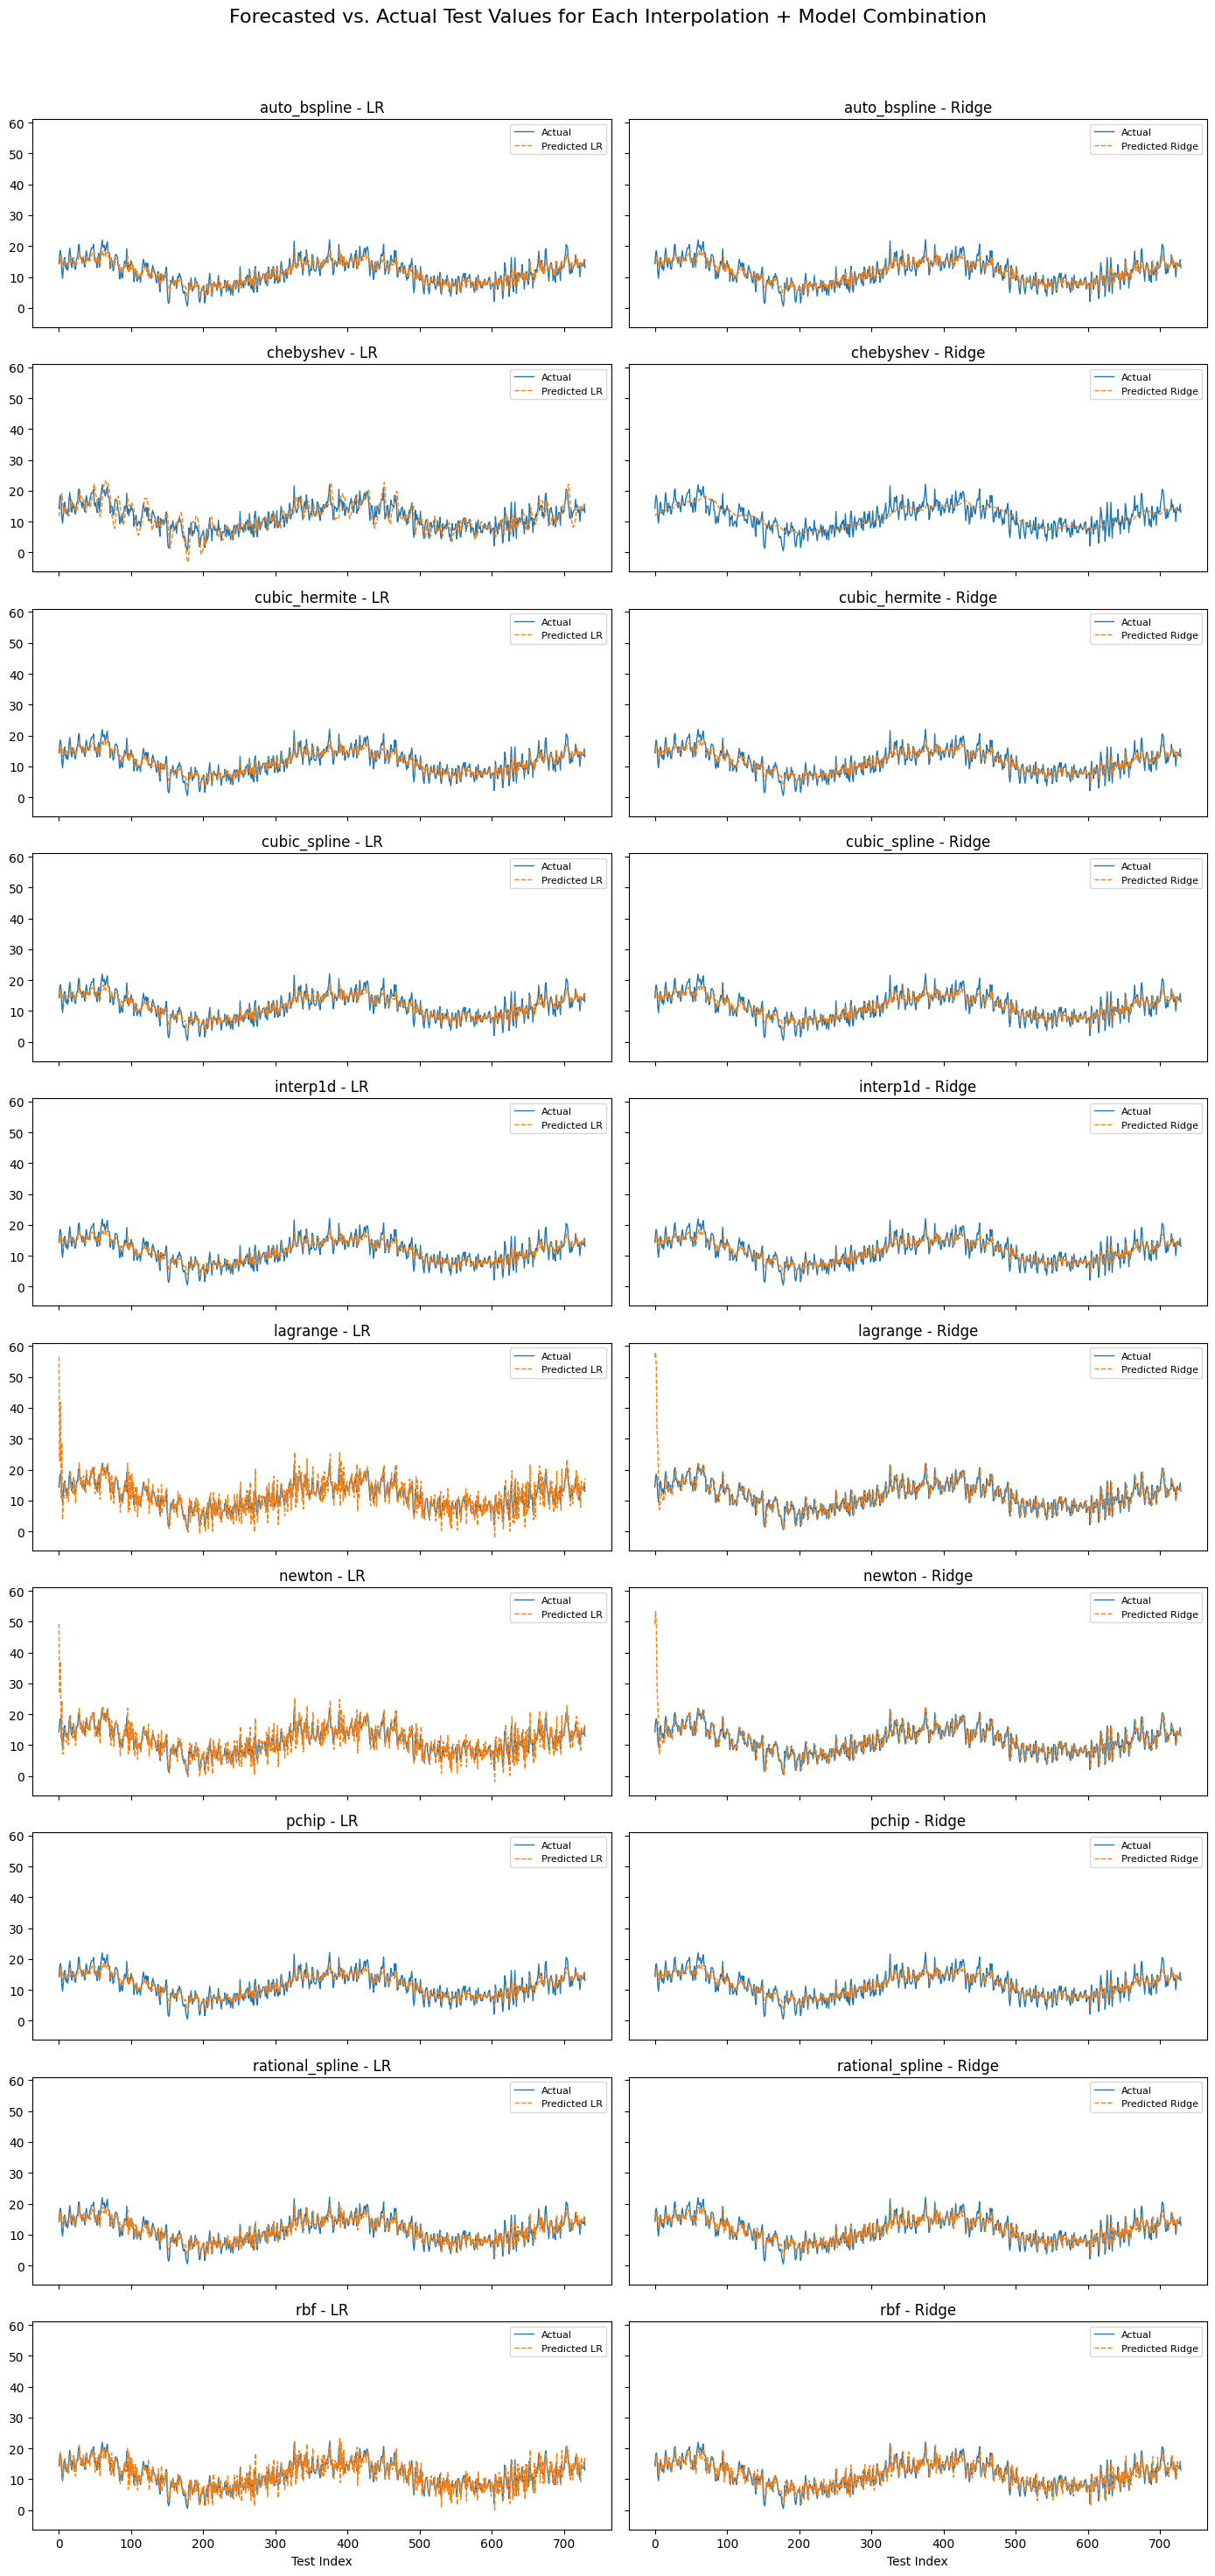

In [27]:
# Compute the actual test target values (in original scale) from the test set
actual_test = scaler.inverse_transform(test_values.reshape(-1, 1)).flatten()

# Get sorted list of interpolation methods (keys)
methods_sorted = sorted(interpolated_methods.keys())
n_methods = len(methods_sorted)

# Create a grid: one row per method, two columns (LR and Ridge)
fig, axes = plt.subplots(n_methods, 2, figsize=(14, 3 * n_methods), sharex=True, sharey=True)

# Ensure axes is 2D even if there is only one method
if n_methods == 1:
    axes = np.array([axes])

for i, method in enumerate(methods_sorted):
    # Get predictions for this method
    y_pred_lr = predictions_lr[method]
    y_pred_ridge = predictions_ridge[method]

    # Actual test targets correspond to the first n_pred indices
    n_pred = len(y_pred_lr)
    y_act = actual_test[:n_pred]

    # Left subplot: Linear Regression
    ax_lr = axes[i, 0]
    ax_lr.plot(y_act, label="Actual", linestyle="-", linewidth=1)
    ax_lr.plot(y_pred_lr, label="Predicted LR", linestyle="--", linewidth=1)
    ax_lr.set_title(f"{method} - LR")
    ax_lr.legend(fontsize=8)

    # Right subplot: Ridge
    ax_ridge = axes[i, 1]
    ax_ridge.plot(y_act, label="Actual", linestyle="-", linewidth=1)
    ax_ridge.plot(y_pred_ridge, label="Predicted Ridge", linestyle="--", linewidth=1)
    ax_ridge.set_title(f"{method} - Ridge")
    ax_ridge.legend(fontsize=8)

    # Label x-axis for bottom row only
    if i == n_methods - 1:
        ax_lr.set_xlabel("Test Index")
        ax_ridge.set_xlabel("Test Index")

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Forecasted vs. Actual Test Values for Each Interpolation + Model Combination", fontsize=16)
plt.show()